### Compute the model transferability measurements --> Sampling-wise Learning Curve - Area Under the Curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
datasets = ["cifar10", "mnist", "mnistm", "stl", "svhn", "syn", "usps"]
file_directory = "../../logs/resnet18/"

In [3]:
def extract_floats(s):
    # Regular expression for matching floats
    pattern = r"[-+]?[0-9]*\.?[0-9]+"
    # Find all matches in the string
    matches = re.findall(pattern, s)
    # Convert all matches to float
    floats = [float(match) for match in matches]
    return floats

In [4]:
def read_file(file_path):
    results = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if "Data ratio" in line:
                # Get the value after ":"
                line = line.split(":")[2].strip()
                data_ratio = extract_floats(line.split(",")[0].strip())[0]
                data_volume = extract_floats(line.split(",")[1].strip())[0]
                accuracy = extract_floats(line.split(",")[3].strip())[0]
                results[data_ratio] = accuracy
        return results

/tmp/ipykernel_18583/3754534994.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i + 1)


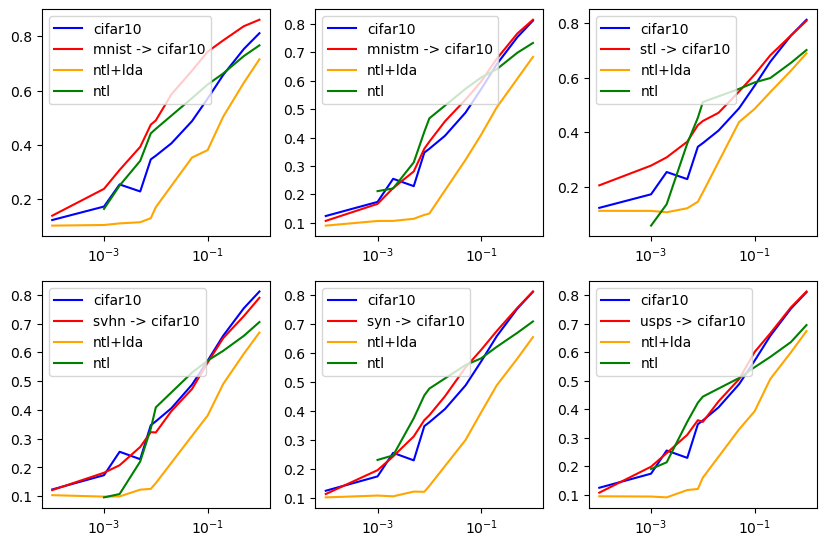

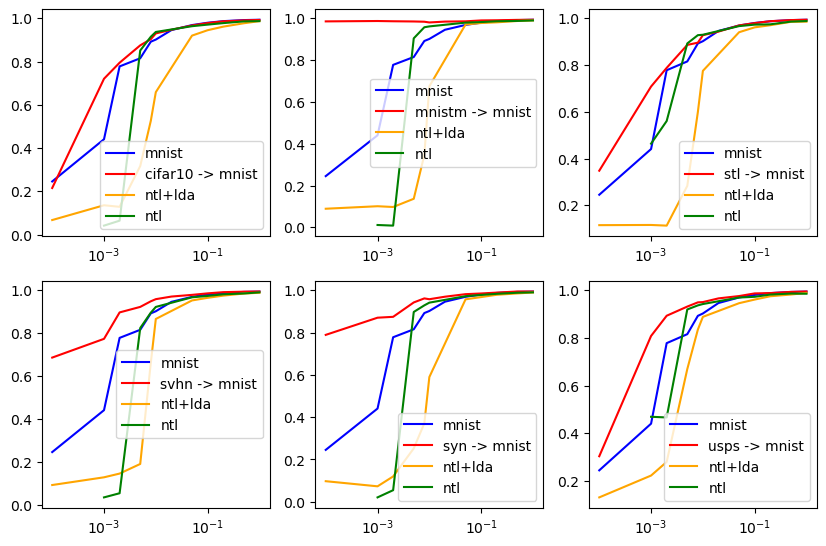

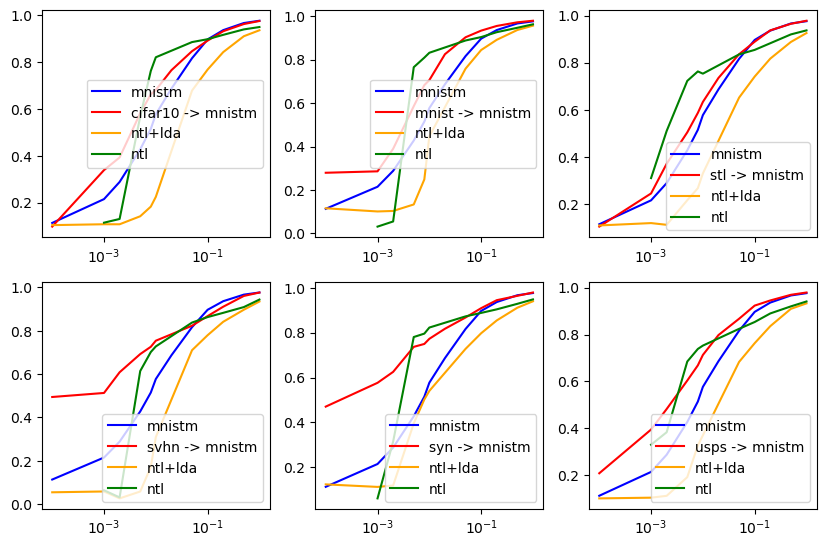

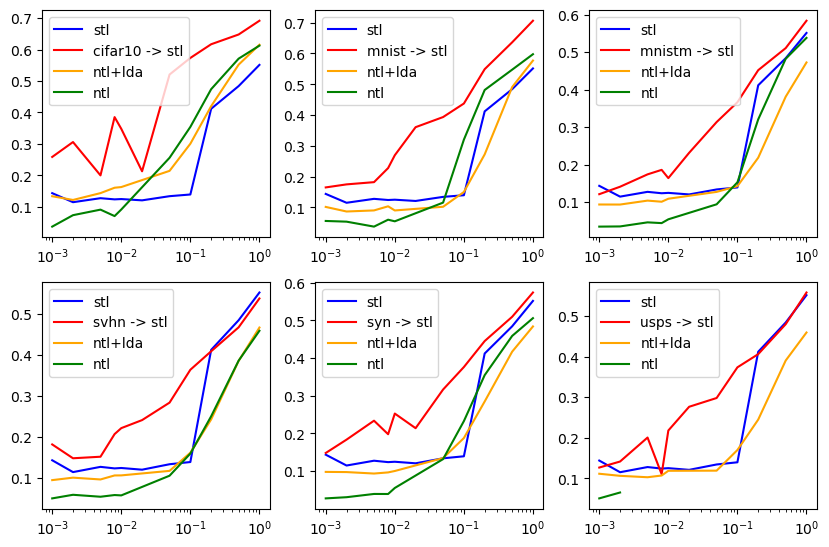

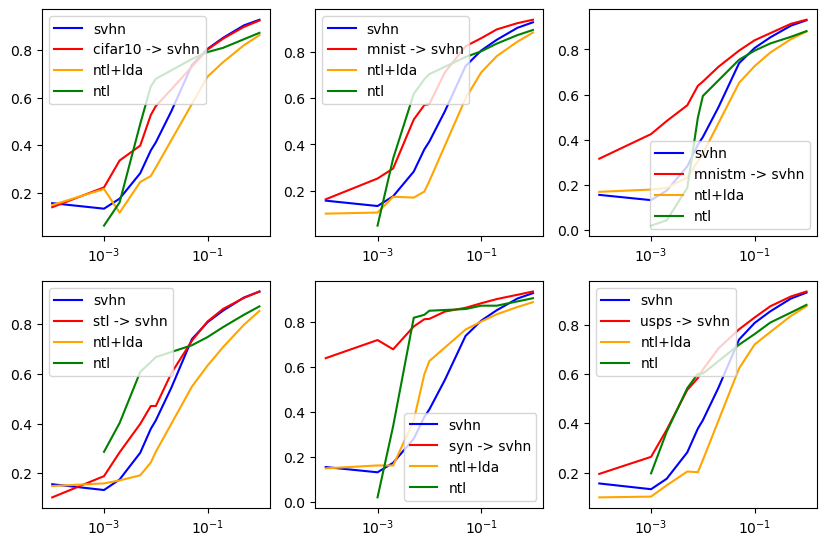

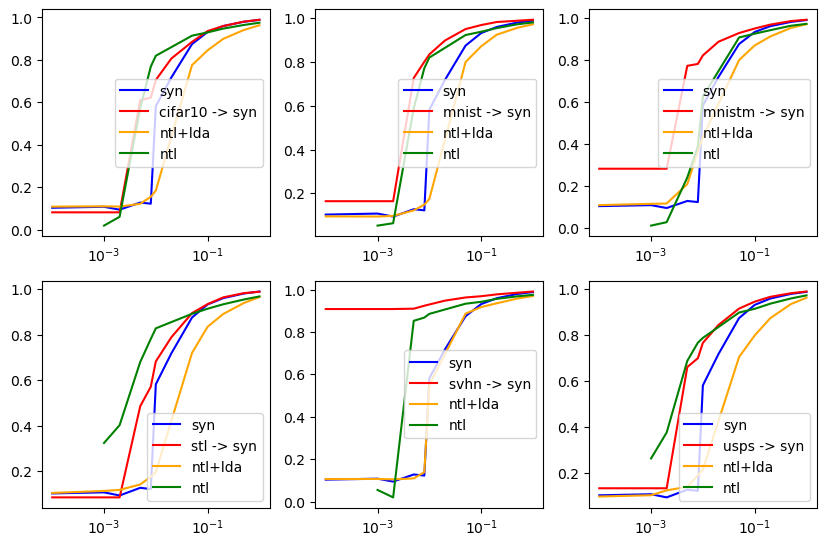

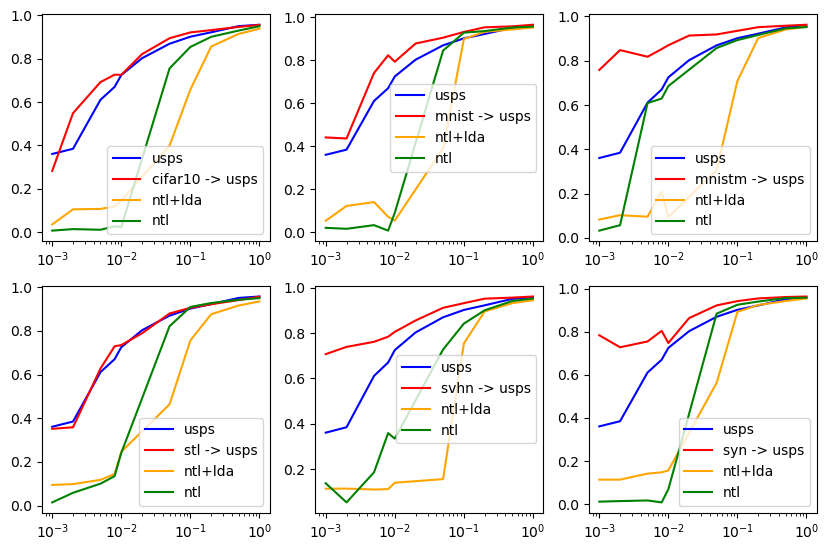

In [5]:
seed = 2
for target in datasets:
    plt.subplots(figsize=(10, 10))
    i = 0
    for source in datasets:    
        if source != target:
            target_path = file_directory + "local/" + target + ".log"
            target_dic = read_file(target_path)
            transfer_path = file_directory + "transfer/" + source + "-" + target + ".log"
            transfer_dic = read_file(transfer_path)
            ntl_lda_path = file_directory + "ntl+lda/admm_" + source + "_to_" + target + ".log"
            ntl_lda_dic = read_file(ntl_lda_path)
            ntl_path = file_directory + f"ntl/{seed}/admm_" + source + "_to_" + target + ".log"
            ntl_dic = read_file(ntl_path)
            x = list(transfer_dic.keys())
            y = list(transfer_dic.values())
            plt.subplot(3, 3, i + 1)
            i += 1
            plt.plot(list(target_dic.keys()), list(target_dic.values()), label=target, color='blue')
            plt.plot(x, y, label=source + " -> " + target, color='red')
            plt.plot(list(ntl_lda_dic.keys()), list(ntl_lda_dic.values()), label="ntl+lda", color='orange')
            plt.plot(list(ntl_dic.keys()), list(ntl_dic.values()), label="ntl", color='green')
            # log scale
            plt.xscale('log')
            plt.legend()

In [15]:
# Given the xaxis (dic.keys()) and yaxis (dic.values()), compute the log scale area under the curve
def log_auc(xaxis, yaxis):
    auc = 0
    for i in range(1, len(xaxis)):
        # log scale area under the curve
        auc += (np.log(xaxis[i]) - np.log(xaxis[i - 1])) * (yaxis[i] + yaxis[i - 1]) / 2
    return auc

In [23]:
# Compute the log scale area under the curve for all datasets
local = {}
for target in datasets:
    target_path = file_directory + "local/" + target + ".log"
    target_dic = read_file(target_path)
    auc = log_auc(list(target_dic.keys()), list(target_dic.values()))
    print(f"{target}: {auc}")
    local[target] = auc

cifar10: 3.5823268935873105
mnist: 7.013460676181942
mnistm: 5.122620219167711
stl: 1.5435900182042148
svhn: 4.367010713897939
syn: 4.584803735710495
usps: 5.232009656462087


In [24]:
# Compute the log scale area under the curve for all transfer learning methods
for target in datasets:
    target_auc = local[target]
    for source in datasets:
        if source != target:
            transfer_path = file_directory + "transfer/" + source + "-" + target + ".log"
            transfer_dic = read_file(transfer_path)
            auc = log_auc(list(transfer_dic.keys()), list(transfer_dic.values()))
            auc = auc - target_auc
            print(f"{source} -> {target}: {auc}")

mnist -> cifar10: 0.9775363610010648
mnistm -> cifar10: 0.1185956916382449
stl -> cifar10: 0.6019587043487786
svhn -> cifar10: -0.08498058118458296
syn -> cifar10: 0.2151180469038141
usps -> cifar10: 0.13195947884655768
cifar10 -> mnist: 0.453063166748338
mnistm -> mnist: 2.0825271329591244
stl -> mnist: 0.5868623338725856
svhn -> mnist: 1.255108855785406
syn -> mnist: 1.519350013362673
usps -> mnist: 0.8567620153374671
cifar10 -> mnistm: 0.5330724941444913
mnist -> mnistm: 0.8334144768821066
stl -> mnistm: 0.25208466514843586
svhn -> mnistm: 1.5179917900494182
syn -> mnistm: 1.769601335767299
usps -> mnistm: 0.9349258733310659
cifar10 -> stl: 1.4691305444590037
mnist -> stl: 1.0899632379208686
mnistm -> stl: 0.5424022353484241
svhn -> stl: 0.48203982049180216
syn -> stl: 0.6548203458639257
usps -> stl: 0.5169531284837545
cifar10 -> svhn: 0.5040179369492543
mnist -> svhn: 0.8776566384832609
mnistm -> svhn: 1.4945345517370168
stl -> svhn: 0.29668574296249783
syn -> svhn: 2.9778976013779

In [25]:
# Compute the log scale area under the curve for all NTL
for target in datasets:
    target_auc = local[target]
    for source in datasets:
        if source != target:

            ntl_path = file_directory + f"ntl/{seed}/admm_" + source + "_to_" + target + ".log"
            ntl_dic = read_file(ntl_path)
            auc = log_auc(list(ntl_dic.keys()), list(ntl_dic.values()))
            auc = auc - target_auc
            print(f"{source} -> {target}: {auc}")

mnist -> cifar10: -0.03761421928402209
mnistm -> cifar10: -0.12805046024116962
stl -> cifar10: -0.2811971671776661
svhn -> cifar10: -0.5521063267699287
syn -> cifar10: -0.12122349730351978
usps -> cifar10: -0.35654014615921614
cifar10 -> mnist: -1.4762548789312548
mnistm -> mnist: -1.4203997234768968
stl -> mnist: -0.9033005582144851
svhn -> mnist: -1.5196768800697438
syn -> mnist: -1.4297434652390733
usps -> mnist: -0.9383533699637159
cifar10 -> mnistm: -0.10668919222007212
mnist -> mnistm: -0.005121404754052428
stl -> mnistm: 0.17886635340401646
svhn -> mnistm: -0.40982903038481844
syn -> mnistm: 0.14440012061639962
usps -> mnistm: 0.044056358031179244
cifar10 -> stl: 0.29340362860727187
mnist -> stl: 0.004243448452335485
mnistm -> stl: -0.3589434744400559
svhn -> stl: -0.4628471509613721
syn -> stl: -0.27568227424686875
usps -> stl: -1.503734055322018
cifar10 -> svhn: 0.037502739777861116
mnist -> svhn: 0.37509068031146153
mnistm -> svhn: -0.39814354085870995
stl -> svhn: 0.25937786

In [26]:
# Compute the log scale area under the curve for all NTL+LDA
for target in datasets:
    target_auc = local[target]
    for source in datasets:
        if source != target:
            ntl_lda_path = file_directory + "ntl+lda/admm_" + source + "_to_" + target + ".log"
            ntl_lda_dic = read_file(ntl_lda_path)
            auc = log_auc(list(ntl_lda_dic.keys()), list(ntl_lda_dic.values()))
            auc = auc - target_auc
            print(f"{source} -> {target}: {auc}")

mnist -> cifar10: -1.1030687362027343
mnistm -> cifar10: -1.2024865051002784
stl -> cifar10: -0.8743986924377967
svhn -> cifar10: -1.246232445028205
syn -> cifar10: -1.2626871949684864
usps -> cifar10: -1.2207919004387477
cifar10 -> mnist: -2.0082233574316515
mnistm -> mnist: -2.1225541671346324
stl -> mnist: -1.8375932491491307
svhn -> mnist: -1.761029618996794
syn -> mnist: -2.1560362242619524
usps -> mnist: -1.0643714655085388
cifar10 -> mnistm: -1.341285377700852
mnist -> mnistm: -0.906025730171578
stl -> mnistm: -1.232641367948442
svhn -> mnistm: -1.4891374451384358
syn -> mnistm: -0.6352254860187907
usps -> mnistm: -1.1275153745579454
cifar10 -> stl: 0.3559904030567589
mnist -> stl: -0.22400259246794407
mnistm -> stl: -0.3366099593963441
svhn -> stl: -0.31270817486748714
syn -> stl: -0.22452036464471536
usps -> stl: -0.2797357851176694
cifar10 -> svhn: -0.5273000496930802
mnist -> svhn: -0.7481071833784805
mnistm -> svhn: -0.29976145831822
stl -> svhn: -0.7615590911778871
syn -> 

/tmp/ipykernel_18583/2581534987.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i + 1)


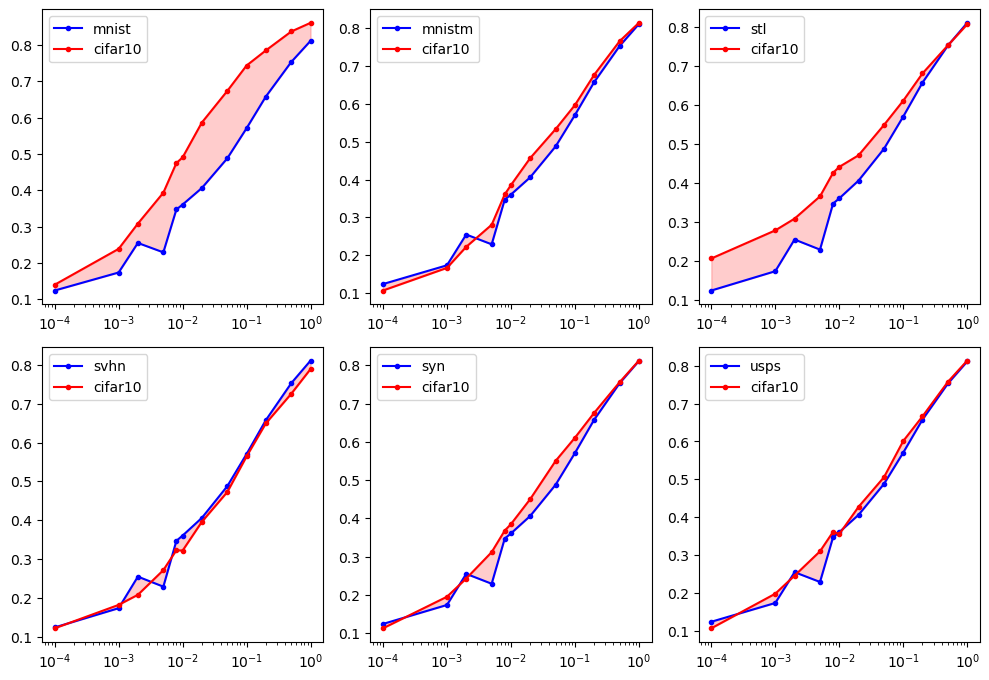

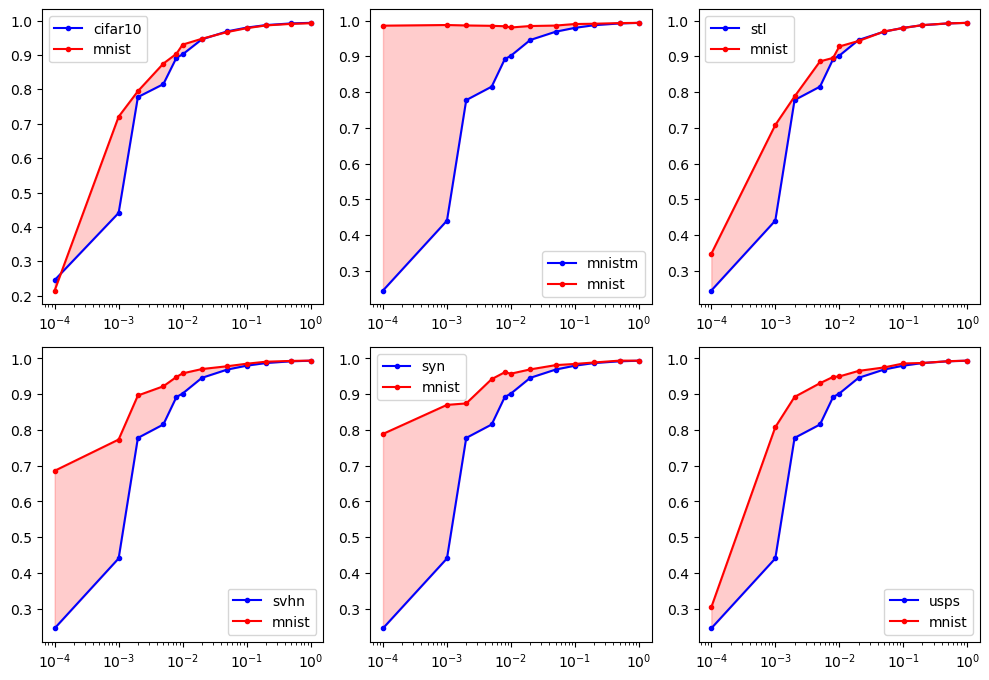

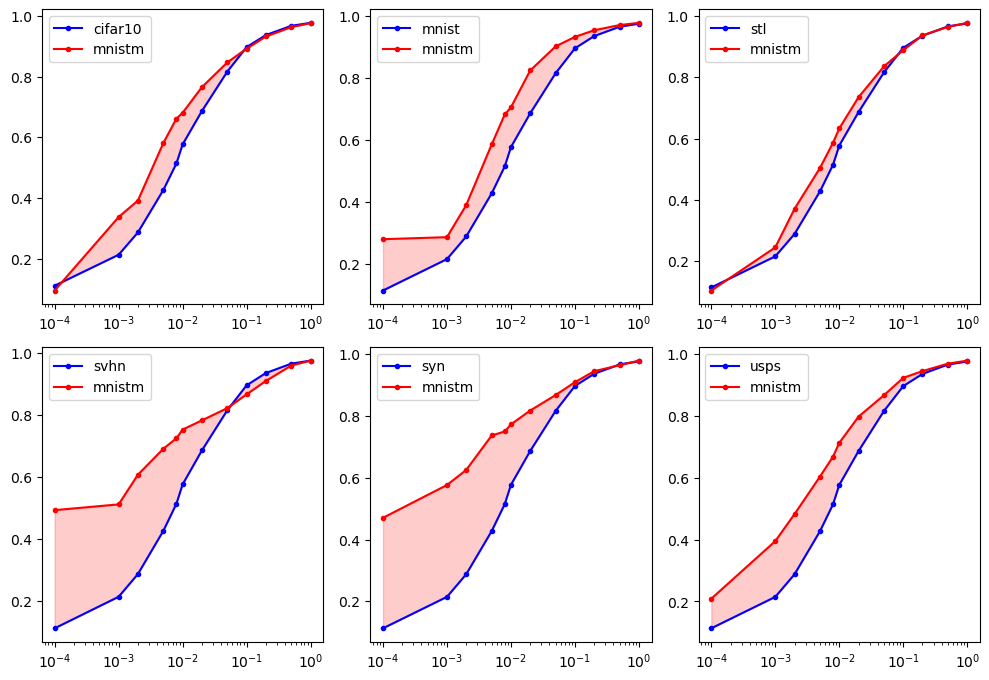

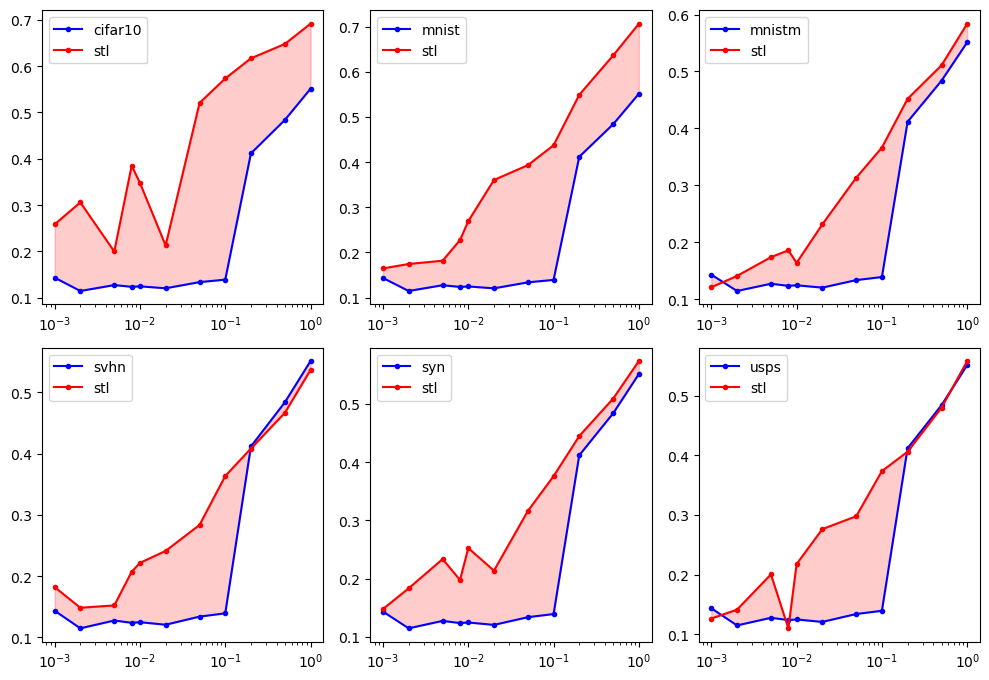

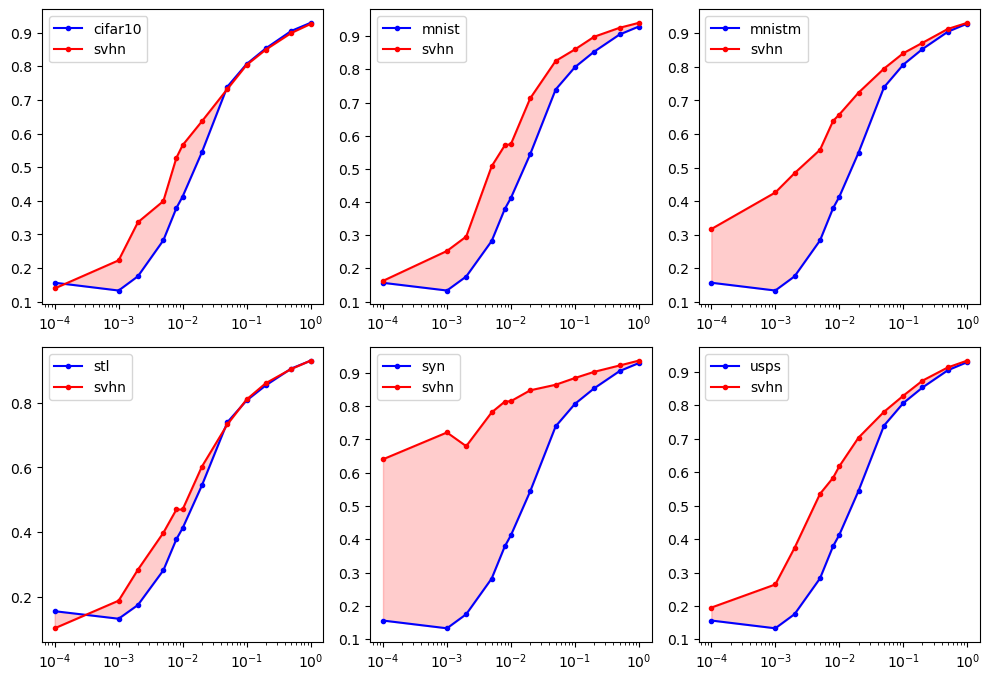

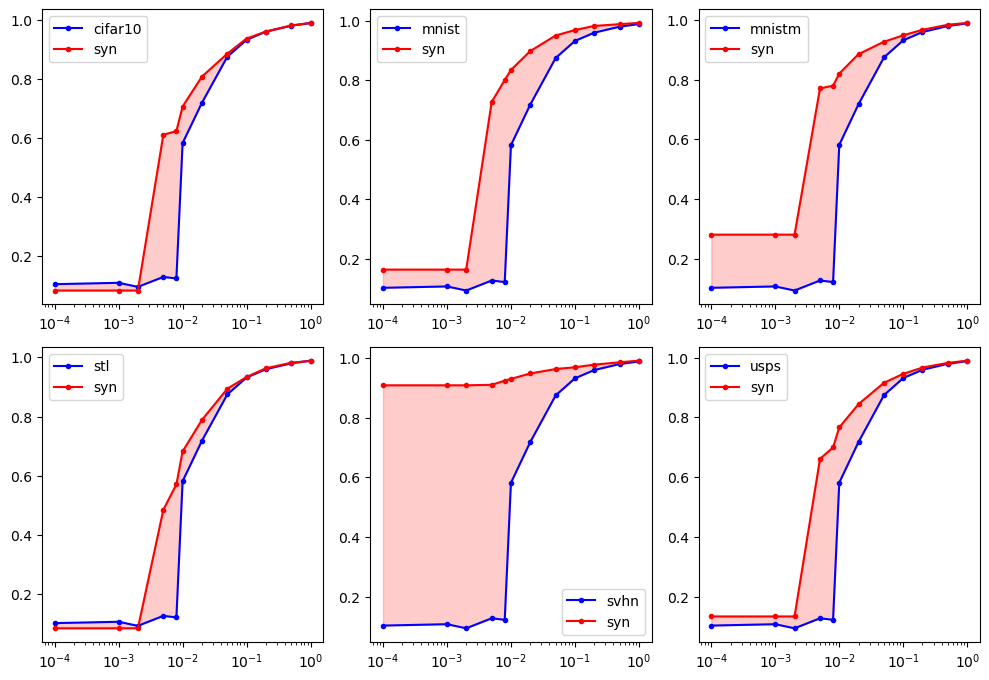

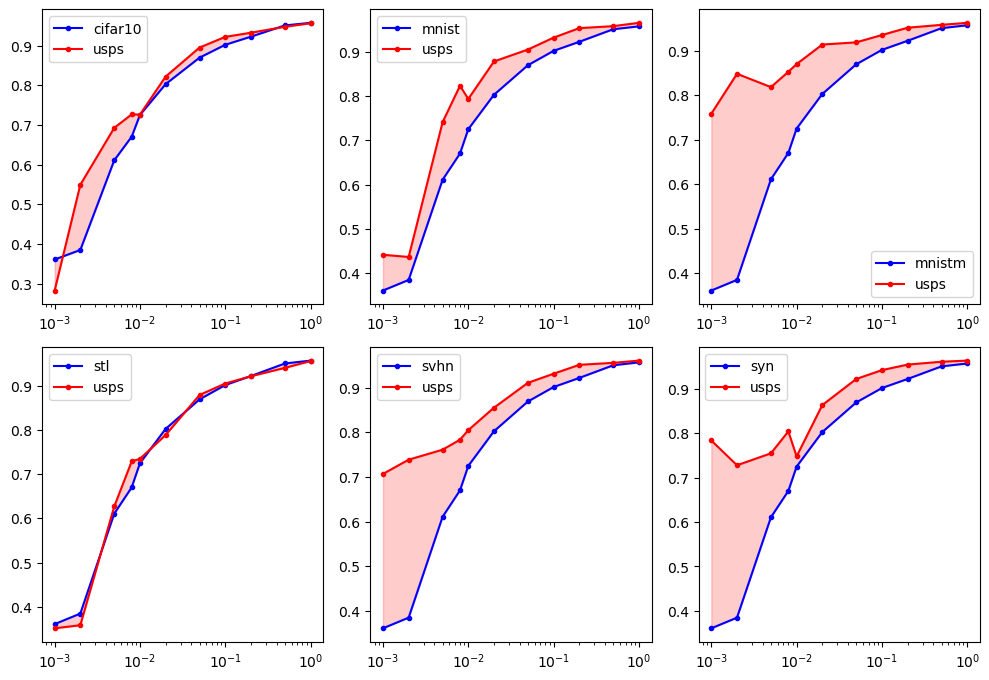

In [39]:
seed = 2
for target in datasets:
    plt.subplots(figsize=(10, 10))
    i = 0
    for source in datasets:    
        if source != target:
            target_path = file_directory + "local/" + target + ".log"
            target_dic = read_file(target_path)
            transfer_path = file_directory + "transfer/" + source + "-" + target + ".log"
            transfer_dic = read_file(transfer_path)
            x = list(transfer_dic.keys())
            y = list(transfer_dic.values())
            x1 = list(target_dic.keys())
            y1 = list(target_dic.values())
            plt.subplot(3, 3, i + 1)
            i += 1
            plt.plot(x1, y1, label=source, color='blue', marker='o', markersize=3)
            plt.plot(x, y, label=target, color='red', marker='o', markersize=3)

            # Draw the area under curve between two curves  
            plt.fill_between(x, y, y1, color='red', alpha=0.2)

            # log scale
            plt.xscale('log')
            plt.legend()
            plt.tight_layout()

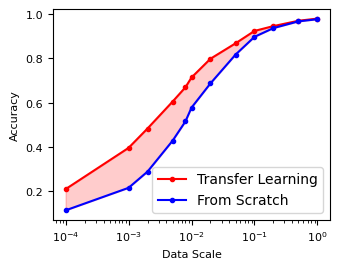

In [58]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(3.5, 2.8))  # Width, height in inches
source="usps"
target="mnistm"
# Plot data
target_path = file_directory + "local/" + target + ".log"
target_dic = read_file(target_path)
transfer_path = file_directory + "transfer/" + source + "-" + target + ".log"
transfer_dic = read_file(transfer_path)
x = list(transfer_dic.keys())
y = list(transfer_dic.values())
x1 = list(target_dic.keys())
y1 = list(target_dic.values())
plt.plot(x, y, label="Transfer Learning", color='red', marker='o', markersize=3)
plt.plot(x1, y1, label="From Scratch", color='blue', marker='o', markersize=3)

# Draw the area under curve between two curves  
plt.fill_between(x, y, y1, color='red', alpha=0.2)

plt.xlabel("Data Scale")
plt.ylabel("Accuracy")
# log scale
plt.xscale('log')
# Set title and labels with font sizes

plt.rcParams.update({"font.size":10, "axes.labelsize":8, "xtick.labelsize":8, "ytick.labelsize":8})

# Adjust layout
plt.tight_layout()
plt.legend()

# Save or display the figure
plt.savefig(f'../../imgs/{source}_to_{target}.svg', dpi=300)  # Save with high resolution
plt.show()
